In [1]:
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans
from msresist.comp_estimator import ComHyperPar, MyOwnKMEANS
from msresist.plsr import MeanCenter, VarianceFilter, FoldChangeFilter, ClusterAverages, GridSearch_CV, MeasuredVsPredicted_LOOCVplot, Q2Y_across_components, R2Y_across_components
from msresist.mining_bioreplicates import FormatName, FormatSeq, MapOverlappingPeptides, BuildDupsMatrix, BuildTripsMatrix, DupsMeanAndRange, TripsMeanAndStd, FilterByRange, FilterByStdev
import scipy as sp, numpy as np, pandas as pd, math
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns; sns.set(color_codes=True)
from FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

## Importing and pre-processing data

### Phosphorylation levels of peptides across conditions | X Matrix where peptides = vars and conditions = obs

Raw Data of all 3 biological replicates:

In [2]:
A_r = pd.read_csv('./msresist/data/Raw/20180817_JG_AM_TMT10plex_R1_psms_raw.csv', header=0)
B_r = pd.read_csv('./msresist/data/Raw/20190214_JG_AM_PC9_AXL_TMT10_AC28_R2_PSMs_raw.csv', header=0)
C_r = pd.read_csv('./msresist/data/Raw/CombinedBR3_TR1&2_raw.csv', header=0)

In [3]:
treatments = A_r.columns[2:]
header = A_r.columns

#### Normalization 1: Linear Fold Change values wrt PC9 untreated cell population.

Biological replicates normalized by fold-change to the control:

In [4]:
A_fc = pd.read_csv('./msresist/data/Fold-Change/20180817_JG_AM_TMT10plex_R1_psms.csv', header=0)
B_fc = pd.read_csv('./msresist/data/Fold-Change/20190214_JG_AM_PC9_AXL_TMT10_AC28_R2_PSMs.csv', header=0)
C_fc = pd.read_csv('./msresist/data/Fold-Change/CombinedBR3_TR1&2.csv', header=0)

#### Normalization 2: Linear mean centered across conditions.

In [5]:
A_mc = MeanCenter(A_r, logT=True)
B_mc = MeanCenter(B_r, logT=True)
C_mc = MeanCenter(C_r, logT=True)

###                                                    Filtering and Merging of biological replicates

Concatenate and format peptide sequences

In [6]:
ABC_fc = FormatSeq(pd.concat([A_fc, B_fc, C_fc]))
ABC_fc['Master Protein Descriptions'] = FormatName(ABC_fc)

ABC_mc = FormatSeq(pd.concat([A_mc, B_mc, C_mc]))
ABC_mc['Master Protein Descriptions'] = FormatName(ABC_mc)

Build dataframe inidicating the number of recurrencies of each peptide: 1,2 or 3. From this dataframe we manually created two csv files () containing all duplicates. Finally, generate counter to see number of non-recurrent peptides, duplicates and triplicates:

In [7]:
recurrencies = MapOverlappingPeptides(ABC_fc)

total number of recurrences: {1: 620, 2: 246, 3: 128}


Import duplicates and triplicates (cols = Names, Seqs, #Recurrences):

In [8]:
duplicated_ = pd.read_csv('./msresist/data/Fold-Change/ABC_Duplicates.csv', header=0)
triplicated_ = pd.read_csv('./msresist/data/Fold-Change/ABC_Triplicates.csv', header=0)

Sort all duplicates and triplicates within the concatenated dataframe in two seperate matrices:

In [9]:
FC_dups = BuildDupsMatrix(duplicated_, ABC_fc)
FC_trips = BuildTripsMatrix(triplicated_, ABC_fc)

MC_dups = BuildDupsMatrix(duplicated_, ABC_mc)
MC_trips = BuildTripsMatrix(triplicated_, ABC_mc)

Merge overlapping peptides by computing the mean. Keep range and stdev for filter criteria. Note: Need to find a way to get pearson's correlation instead of using range. For the range we take values of the same condition but for pearson we want two compare the entire list of values between overalapping peptides.

In [10]:
FC_dups_MeanPtp = DupsMeanAndRange(FC_dups, treatments, header)
FC_trips_MeanStd = TripsMeanAndStd(FC_trips, treatments, header)

MC_dups_MeanPtp = DupsMeanAndRange(MC_dups, treatments, header)
MC_trips_MeanStd = TripsMeanAndStd(MC_trips, treatments, header)

Filter by range or standard deviation:

In [11]:
FC_dups_VarF = FilterByRange(FC_dups_MeanPtp, header)
FC_trips_VarF = FilterByStdev(FC_trips_MeanStd, header)

MC_dups_VarF = FilterByRange(MC_dups_MeanPtp, header)
MC_trips_VarF =FilterByStdev(MC_trips_MeanStd, header)

Concatenate resulting matrices:

In [12]:
FC_VarF = pd.concat([FC_dups_VarF, FC_trips_VarF]).sort_values(by = "Master Protein Descriptions")

MC_VarF = pd.concat([MC_dups_VarF, MC_trips_VarF]).sort_values(by = "Master Protein Descriptions")

Filter by fold-change or variance:

In [13]:
FC_VarF_FoldF = FoldChangeFilter(FC_VarF)
FC_VarF_FoldF.iloc[:,2:] = np.log2(FC_VarF_FoldF.iloc[:,2:])
FC_VarF_FoldF_data = FC_VarF_FoldF.iloc[:,2:].T

MC_VarF_VarF = VarianceFilter(MC_VarF)
MC_VarF_VarF_data = MC_VarF_VarF.iloc[:,2:].T

### Observations (Y Matrix) = Cell Viability

In [14]:
Y = pd.read_csv('./msresist/data/Phenotypic_data/ydata.csv', header=0)
Y_cv = Y.iloc[:10, 2]

## Phosphopeptides Heat Map

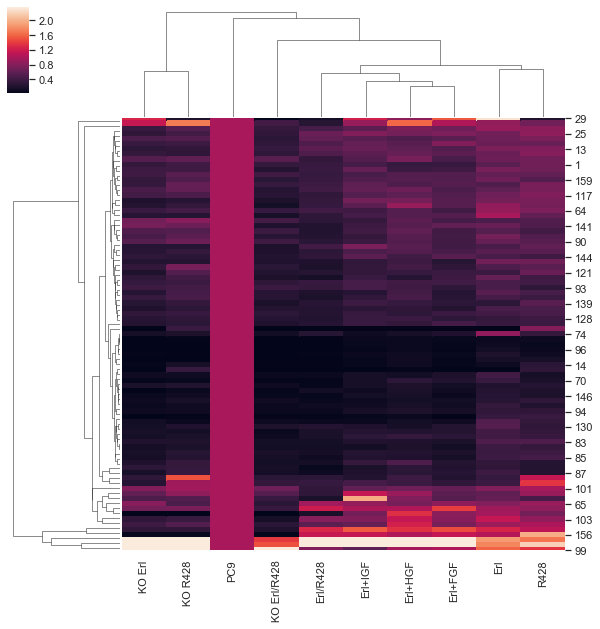

In [15]:
g = sns.clustermap(np.exp(FC_VarF_FoldF_data.copy()).T, method = "average", robust = True)
g

In [16]:
# Xf.iloc[:, 2:] = np.log2(Xf.iloc[:, 2:].values)
# Xf_data = np.log2(Xf_data.values)

In [17]:
# p = g.dendrogram_row.reordered_ind

Recovering heat map peptides 

In [18]:
# p = g.dendrogram_row.reordered_ind

# hm_prots = []
# for i in p:
#     hm_prots.append(Xf.iloc[i,:])
# hm_prots = pd.DataFrame(hm_prots)

## Cell Viability Measurements

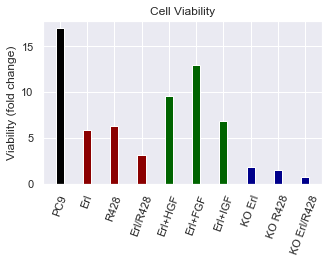

In [19]:
fig, axs = plt.subplots(1,1,figsize=(5,3))
plt.bar(np.linspace(1,10,10)-1, Y_cv,width=0.3,align='center', color=['black', 'darkred', 'darkred', 'darkred', 'darkgreen', 'darkgreen', 'darkgreen', 'darkblue', 'darkblue', 'darkblue'])
plt.xticks(np.arange(10), (treatments), rotation=70)
plt.title("Cell Viability")
plt.ylabel("Viability (fold change)")
# plt.savefig("CellViability.pdf")
plt.show()

## GridSearchCV

Simultaneous hyperparameter tuning of number of clusters and components across entire model pipeline

In [20]:
# param_grid = []
# for nn in range(2, 16):
#     param_grid.append(dict(n_clusters=[nn], n_components= list(np.arange(1, nn + 1))))
# param_grid

In [27]:
estimators = [('kmeans', MyOwnKMEANS(5, list(FC_VarF_FoldF.iloc[:,1]), list(FC_VarF_FoldF.iloc[:,0]))), ('plsr', PLSRegression(2))]
pipe = Pipeline(estimators)

In [30]:
import warnings
warnings.simplefilter("ignore")

CVresults_max, CVresults_min, best_params = ComHyperPar(FC_VarF_FoldF_data, Y_cv, list(FC_VarF_FoldF.iloc[:,1]), list(FC_VarF_FoldF.iloc[:,0]))
# create_download_link(CVresults_min, "GridSearch_ClustVsComp")

ValueError: Invalid parameter n_clusters for estimator Pipeline(memory=None,
         steps=[('kmeans',
                 MyOwnKMEANS(ProtNames=['ADP-ribosylation factor-like protein '
                                        '11 ',
                                        'Actin, cytoplasmic 1 ',
                                        'Actin, cytoplasmic 1 ',
                                        'Actin, cytoplasmic 1 ',
                                        'Activator of 90 kDa heat shock '
                                        'protein ATPase homolog 1 ',
                                        'Adapter molecule crk ', 'Afadin ',
                                        'Annexin A2 ', 'Annexin A2 ',
                                        'Brain-specific angiogenesis inhibitor '
                                        '1-associated protein 2-like protein '
                                        '1 ',
                                        'Cate...
                                                  'YEDGYPGGSDNyGSLSR',
                                                  'PcAyDkTALALEVGDIVk',
                                                  'GEGTyGTVFk', 'PyAHISIPR',
                                                  'VPLyESPR', 'VPIyANR',
                                                  'yVTIIDAPGHR', 'VPVGyGIR',
                                                  'yDFPPPMR', 'kDyDFPPPMR',
                                                  'GHGYVyEYPSR',
                                                  'WMDDYDyVHLQGk',
                                                  'TENNYcPHyEk',
                                                  'SHQISLDNPDyQQDFFPk',
                                                  'DPPyTHTIQk', 'QIPEGDyLSYR',
                                                  'VGyETILk', 'PDGyEFk',
                                                  'VyATTVGTPYk', ...])),
                ('plsr',
                 PLSRegression(copy=True, max_iter=500, n_components=2,
                               scale=True, tol=1e-06))],
         verbose=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
print(best_params)
display(CVresults_min.iloc[:20,:])

# MSE = np.abs(CVresults_min.iloc[:20, 2])

In [ ]:
#range_ = np.linspace(1,MSE.shape[0],MSE.shape[0])

#fig, axs = plt.subplots(1,1,figsize=(7,5))
#plt.setp(axs, xticks=range_)
#plt.bar(range_,MSE,width=0.3,align='center', color = "green")
# plt.savefig("GridSearch_Cl&Comp.pdf")
#plt.title("GridSearch Cell Viability")
#plt.xlabel("Number of Components")
#plt.ylabel("MSE")
#plt.show()

In [ ]:
raise SystemExit

### R2Y / Q2Y

Percentages of variance explained (R2Y) and predicted (Q2Y) across numbers of components

In [ ]:
import warnings
warnings.simplefilter("ignore")

maxComp = 10
Q2Y = Q2Y_across_components(Xf_data, Y_cv, maxComp+1)
R2Y = R2Y_across_components(Xf_data, Y_cv, maxComp+1)

First using the entire data set

In [ ]:
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,spac1,spac2,dec):
    for l, m in enumerate(x):
        plt.text(l+spac1,m+spac2,str(truncate(m,dec)))    #change to axs[ax].

range_ = np.linspace(1,maxComp,maxComp)

fig, axs = plt.subplots(1,1,figsize=(9,7))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkred")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=4)
disp_values(Q2Y,1.03,0.01,3)
disp_values(R2Y,0.6,0.01,3)

Then after k-means clustering setting the number of clusters to 5

In [ ]:
kmeans = MyOwnKMEANS(5, Xf_protnames, Xf_seqs).fit(Xf_data, Y=None)
centers = kmeans.transform(Xf_data)
clustermembers = kmeans.ClusterMembers(Xf_data)

In [ ]:
maxComp = centers.shape[1]
Q2Y = Q2Y_across_components(centers, Y_cv, maxComp)
R2Y = R2Y_across_components(centers, Y_cv, maxComp)

In [ ]:
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,spac1,spac2,dec):
    for l, m in enumerate(x):
        plt.text(l+spac1,m+spac2,str(truncate(m,dec)))    #change to axs[ax].

range_ = np.linspace(1,maxComp-1,maxComp-1)

fig, axs = plt.subplots(1,1,figsize=(5,3))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkblue")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=4)
disp_values(Q2Y,1.03,0.02,3)
disp_values(R2Y,0.74,0.01,3)
# plt.savefig("R2YQ2Y_BR1_5Cl.pdf")

## Building chained k-means and PLSR model pipeline

### Measured Vs Predicted

We've learnt during cross-validation that by setting the number of components to 2 and the number of clusters to 5 the model should perform reasonably well at predicting the viability response across conditions. To corroborate that we plot measured vs predicted below. We also show that the model performs better after clustering than using the entire data set, or even the filtered data set. 

In [ ]:
ncl, ncomp = 6, 2
estimators = [('kmeans', MyOwnKMEANS(ncl, Xf_protnames, Xf_seqs)), ('plsr', PLSRegression(ncomp))]
pipe = Pipeline(estimators)

In [ ]:
X_scores, Y_scores = pipe.fit_transform(Xf_data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = pipe.named_steps.plsr.x_loadings_[:, 0], pipe.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = pipe.named_steps.plsr.y_loadings_[:, 0], pipe.named_steps.plsr.y_loadings_[:, 1]

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(Xf_data,Y_cv, pipe, fig, "none", axs)
plt.title("Correlation Measured vs Predicted - CV across pipeline")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability")
#textstr = '\n'.join(['R: 0.79', 'p-value: 0.006'])
#props = dict(boxstyle = 'square', facecolor = "white", alpha = 0.5)
#plt.text(0.5, 14.7, textstr, bbox=props)
# plt.savefig('Measured_Predict_5cl2co_pipe.pdf')
plt.show()

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(X_data,Y_cv, PLSRegression(ncomp), fig, "none", axs)
plt.title("Correlation Measured vs Predicted - Fixed Clustered Df")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability")
textstr = '\n'.join(['R: 0.79', 'p-value: 0.006'])
props = dict(boxstyle = 'square', facecolor = "white", alpha = 0.5)
plt.text(0.1, 10.5, textstr, bbox=props)
# plt.savefig('Measured_Predict_5cl2co_pipe.pdf')
plt.show()

### Scores and Loadings Plot

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))
# colors_ = cm.rainbow(np.linspace(0, 1, 5))
colors_ = ["blue", "orange", "green", "red", "purple"]


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[0].set_xlim([-5, 5])
axs[0].set_ylim([-1.75, 1.75])

for i, txt in enumerate(["1", "2", "3", "4", "5"]):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].legend(loc=4)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([-0.65, 0.65])
axs[1].set_ylim([-1.1, 1.1])
# plt.savefig('scores_loadings.pdf')
plt.show()

In [ ]:
ClusterMembers = pipe.named_steps.kmeans.ClusterMembers(Xf_data)
count = sum(len(v) for v in ClusterMembers.values())
CM_df = pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in ClusterMembers.items() ]))
# create_download_link(CM_df, 'fsdf')

### Cluster Averages across Conditions

In [ ]:
Centers = pipe.named_steps.kmeans.transform(Xf_data)
memb = pipe.named_steps.kmeans.ClusterMembers(Xf_data)


fig = plt.figure(figsize=(6,4))

colors_ = ["blue", "orange", "green", "red", "purple"]

centersT = np.transpose(Centers)
for i in range(centersT.shape[0]):
    plt.plot(centersT[i,:], label = "cluster "+str(i+1), color = colors_[i])
    
plt.xticks(np.arange(centersT.shape[1]), (treatments), rotation=70)
# plt.legend(loc=2, prop={'size':8})
# plt.savefig("ClAvgAcrossCond_BR1.pdf")
plt.show()
display(pd.DataFrame(centersT))
